# Working with Open3D

# Convert a .laz file to .LAS 
#### Needs python = 3.8

In [1]:
import sys
import traceback
import laspy
import os
try:
    print('Running LAZ_to_LAS.py')
    
    def convert_laz_to_las(in_laz, out_las):
        las = laspy.read(in_laz)
        las = laspy.convert(las)
        las.write(out_las)        
    
    in_dir = './'
    
    for (dirpath, dirnames, filenames) in os.walk(in_dir):
        for inFile in filenames:
            if inFile.endswith('.zlas'):
                print("entered here")	
                in_laz = os.path.join(dirpath,inFile)
                
                out_las = in_laz.replace('zlas', 'las') 
                print('working on file: ',out_las)
                convert_laz_to_las(in_laz, out_las)
                             
    print('Finished without errors - LAZ_to_LAS.py')
except:
    tb = sys.exc_info()[2]
    tbinfo = traceback.format_tb(tb)[0]
    print('Error in read_xmp.py')
    print ("PYTHON ERRORS:\nTraceback info:\n" + tbinfo + "\nError Info:\n" + str(sys.exc_info()[1]))  

Running LAZ_to_LAS.py
Finished without errors - LAZ_to_LAS.py


## Visualization with open3D

In [1]:
import open3d as o3d
import laspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [39]:
#used to load .las data into a laspy object.
def load_laspy(las_location):
      input_las = laspy.read(las_location)
      
      return input_las

#used to return a list of unique classifications present in the input LAS file.
def get_list_classifications(input_las):
    classifications = list(set(input_las.classification))
    classifications.sort()
    
    return classifications

#Used to return a Python dictionary of laspy objects of the entire dataset as well as individual classifications.
def get_classifications_laspy(input_las):
    #get a unique list of the classifications currently contained in the dataset.
    classifications = get_list_classifications(input_las=input_las)
    #create dictionary with complete data for each province
    d = {"original_dataset": input_las}
    print("The classifications contained in this .las dataset are: ")
    print(classifications)
    print("Creating a python dictionary containing the entire dataset and individual classifications as separate laspy objects.")
    for classification in classifications:
        print("Saving classification number: " +str(classification))
        classified_points = laspy.create(point_format=input_las.header.point_format, file_version=input_las.header.version)
        classified_points.points = input_las.points[input_las.classification == classification]
        
        d["classification_{}".format(str(classification))] = classified_points
    
    return d

#Optional function which takes the dictionary of laspy objects and converts every classification
#   into individual .LAS files 
def laspy_classifications_to_las(classifications_laspy):
    for classification_las in classifications_laspy:
        if classification_las == "original_dataset":
            pass
            print("skipped exporting the original dataset.")
        else:
            print("processing {} to a LAS file: ".format(classification_las))
            print(classifications_laspy[classification_las])
            classifications_laspy[classification_las].write("classification_{}.las".format(classification_las.split("_")[1]))
            print("done")

# Convert a .LAS file into a pandas object.
def convert_laspy_pandas(input_las):
    # Convert data into pandas DataFrame
    df = pd.DataFrame({"X":input_las.X,"Y":input_las.Y,"Z":input_las.Z,
      "x":np.array(input_las.x),"y":np.array(input_las.y),"z":np.array(input_las.z),
     'intensity': input_las.intensity,
      'classification': input_las.classification,
      'return_number': np.array(input_las.return_number),
      'number_of_returns':np.array(input_las.number_of_returns),
      'synthetic':np.array(input_las.synthetic),
      'key_point':np.array(input_las.key_point),
      'withheld':np.array(input_las.withheld),
      'overlap':np.array(input_las.overlap),
      'scanner_channel':np.array(input_las.scanner_channel),
      'scan_direction_flag':np.array(input_las.scan_direction_flag),
      'user_data':input_las.user_data,
      'scan_angle':input_las.scan_angle,
      'point_source_id':input_las.point_source_id,
      'gps_time':input_las.gps_time    
      })

    return df

def get_selected_classes(classifications,input_las):
    classes = get_list_classifications(input_las=input_las)
    available_classes = classes
    available_classes.append(1000) #to represent the entire dataset
    class_selections = []
    current_selection = -10

    while current_selection == -10:
        print("Available classifications: " + str(available_classes))
        try:
            current_selection = input("Enter a number from the list of available classifications. To get the full dataset enter 1000 : \n")
            if current_selection.isnumeric() == False:
                print("Invalid Character Input.")
                raise ValueError()
            current_selection = int(current_selection)
            if current_selection not in available_classes:
                print("The classification number you selected: {}, is not an available class item.".format(current_selection))
                cancel = input("Would you like to exit instead? 'Y/N' ").upper() + "Y"
                if cancel[0] == "Y":
                    current_selection = -1000
                    print("Exiting and returning empty classification selection list.")
                    class_selections = []    
                else: 
                    raise ValueError()
            if (current_selection != -1000) & (current_selection != 1000):

                if 1000 in available_classes:
                    available_classes.remove(1000)
                class_selections.append(current_selection)
                print("Class {} added to dataframe.".format(str(current_selection)))
                available_classes.remove(current_selection)
                ask = input("Would you like to add another classification to the dataframe? 'Y/N' ").upper() + "Y"

                #If user prompts to add another classification, reset variable and start again.
                if ask[0] == "Y":
                    current_selection = -10
                #If user prompts to stop, exit loop and create pandas dataframe.
                else:
                    print("Classifications have been selected.")
                    class_selections.sort()

            elif current_selection == 1000:
                print("The entire dataset has been selected")
                class_selections = get_list_classifications(input_las=input_las)
                print("All classes have been added to the dataframe.")
                class_selections.sort()

        except ValueError:
            print("Please select an input from the available classification list. \n")
            current_selection = -10

    
    return class_selections

def create_combined_classifications_dataframe(class_selections,df):
    if len(class_selections) > 0:
        #initialize the dataframe with the first set of classifications
        combined_df = df.loc[df["classification"] == class_selections[0]]
        #iterate and append remaining classifications 
        for selection in class_selections[1:]:
            combined_df=pd.concat([combined_df, df.loc[df["classification"] == selection]])
    else:
        combined_df = pd.DataFrame()

    return combined_df

def create_laspy_from_dataframe(input_las,combined_df):
    classified_points = laspy.create(point_format=input_las.header.point_format, file_version=input_las.header.version)
    classified_points.X = combined_df["X"]
    classified_points.Y = combined_df["Y"]
    classified_points.Z = combined_df["Z"]
    classified_points.intensity = combined_df["intensity"]
    classified_points.classification = combined_df["classification"]

    return classified_points

def get_numpy_points_from_laspy_scaled(classified_points):
    point_records = classified_points.points.copy()
    # getting scaling and offset parameters
    las_scaleX = classified_points.header.scale[0]
    las_offsetX = classified_points.header.offset[0]
    las_scaleY = classified_points.header.scale[1]
    las_offsetY = classified_points.header.offset[1]
    las_scaleZ = classified_points.header.scale[2]
    las_offsetZ = classified_points.header.offset[2]
    # calculating coordinates
    p_X = np.array((point_records.X * las_scaleX) + las_offsetX) 
    p_Y = np.array((point_records.Y * las_scaleY) + las_offsetY)
    p_Z = np.array((point_records.Z * las_scaleZ) + las_offsetZ)

    classified_points_numpy = np.array(list(zip(p_X,p_Y,p_Z)))

    return classified_points_numpy


def get_numpy_points_from_laspy_unscaled(classified_points):
    point_records = classified_points.points.copy()
    # calculating coordinates
    p_X = np.array(point_records.X)
    p_Y = np.array(point_records.Y)
    p_Z = np.array(point_records.Z)

    classified_points_numpy = np.array(list(zip(p_X,p_Y,p_Z)))

    return classified_points_numpy

def get_numpy_points_from_pandas_unscaled(combined_df):

    classified_points_numpy = np.array(list(zip(np.array(combined_df["X"]),
                                    np.array(combined_df["Y"]),
                                    np.array(combined_df["Z"]))))

    return classified_points_numpy

def get_numpy_points_from_pandas_scaled(combined_df):

    classified_points_numpy = np.array(list(zip(np.array(combined_df["x"]),
                                    np.array(combined_df["y"]),
                                    np.array(combined_df["z"]))))

    return classified_points_numpy

#input numpy array to visualize using open3d
def visualize_las(classified_points,df= pd.DataFrame()):
        
    dataset = classified_points
    geom = o3d.geometry.PointCloud()
    geom.points = o3d.utility.Vector3dVector(dataset)
    #geom.colors = o3d.utility.Vector3dVector(x)
    #print(df)

    if df.empty is False:
        print("entered df")
        #coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=df.X[0], origin=[df.X.mean(), df.Y.mean(), df.Z.mean()])
        coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.5, origin=[df.X.mean(),df.Y.mean(),df.Z.mean()])
        #coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.5, origin=[0,0,0])
        o3d.visualization.draw_geometries([coord,geom])
        #o3d.visualization.draw_geometries([geom])

    else:
        o3d.visualization.draw_geometries([geom])
        print("did not enter df")
    

def multiple_classifications_to_las(classified_points,class_selections):
    ##write to a .las file
    class_selections.sort()
    sorted_classes_str = "_".join(map(str,class_selections))
    las_file_name = "classifications_" + sorted_classes_str +".las"
    classified_points.write(las_file_name)
    print("Created file: " + sorted_classes_str)




In [40]:
input_las = load_laspy('Tile65_Original_Clean_Macro.las')


In [41]:
input_las

<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 1475679 points, 0 vlrs)>

In [42]:
df = convert_laspy_pandas(input_las=input_las)

In [43]:
df

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
0,290988240,-186802461,-278,290988.240,4813197.539,-0.278,2474,9,1,1,0,0,0,0,0,1,1,-1685,2610,135243.776060
1,290987469,-186802282,-237,290987.469,4813197.718,-0.237,1869,9,1,1,0,0,0,0,0,1,1,-1667,2610,135243.776074
2,290987360,-186802266,-267,290987.360,4813197.734,-0.267,4226,9,1,1,0,0,0,0,0,1,1,-1664,2610,135243.776076
3,290987251,-186802246,-286,290987.251,4813197.754,-0.286,16268,9,1,1,0,0,0,0,0,1,1,-1662,2610,135243.776078
4,290987142,-186802229,-314,290987.142,4813197.771,-0.314,2284,9,1,1,0,0,0,0,0,1,1,-1659,2610,135243.776080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475674,291014354,-186957702,-13723,291014.354,4813042.298,-13.723,1116,0,4,4,0,0,0,0,0,0,4,2718,2812,135839.348992
1475675,291017691,-186957217,-15297,291017.691,4813042.783,-15.297,872,0,5,5,0,0,0,0,0,0,4,2658,2812,135839.349064
1475676,291013483,-186958110,-13518,291013.483,4813041.890,-13.518,799,0,4,4,0,0,0,0,0,0,4,2730,2812,135839.358309
1475677,291018905,-186957521,-15309,291018.905,4813042.479,-15.309,870,0,3,3,0,0,0,0,0,0,4,2634,2812,135839.358424


In [24]:
# Read .las file with the load_laspy() function. Note we cannot handle .laz data.
input_las = load_laspy('Tile65_Original_Clean_Macro.las')

#input_las = load_laspy('train_small.lasd')

#input_las = load_laspy("200-145324069_ground.las")
#Obtain the classifications available for the dataset
classifications = get_list_classifications(input_las=input_las)
#Create a python dictionary containing the original dataset
# as well as classifications in individual laspy objects.
classifications_laspy =  get_classifications_laspy(input_las=input_las)

#If we choose to export each classification into individual .las files.
#laspy_classifications_to_las(classifications_laspy=classifications_laspy)

#Create a pandas dataframe containing the entire pointcloud.
df = convert_laspy_pandas(input_las=input_las)
#Create a pandas dataframe for ground class "2"
if len(df[df["classification"] == 2]) > 0:
    ground = df[df["classification"] == 2]
#Create a pandas dataframe for low veg class "3"
if len(df[df["classification"] == 3]) > 0:
    low_veg = df[df["classification"] == 3]
#Create a pandas dataframe for med veg class "4"
if len(df[df["classification"] == 4]) > 0:
    med_veg = df[df["classification"] == 4]
#Create a pandas dataframe for high veg class "5"
if len(df[df["classification"] == 5]) > 0:
    high_veg = df[df["classification"] == 5]
#Create a pandas dataframe for high veg class "7"
if len(df[df["classification"] == 7]) > 0:
    low_noise = df[df["classification"] == 7]
#Create a pandas dataframe for high veg class "9"
if len(df[df["classification"] == 9]) > 0:
    topo_water_surface = df[df["classification"] == 9]
#Create a pandas dataframe for high noise "18"
if len(df[df["classification"] == 18]) > 0:
    high_noise = df[df["classification"] == 18]
#Create a pandas dataframe for classified bathymetry "40"
if len(df[df["classification"] == 40]) > 0:
    bathymetry = df[df["classification"] == 40]
#Create a pandas dataframe for classified bathymetric water surface "41"
if len(df[df["classification"] == 41]) > 0:
    bathymetric_water = df[df["classification"] == 41]
#Create a pandas dataframe for classified derived water surface "42"
if len(df[df["classification"] == 42]) > 0:
    derived_water_surface = df[df["classification"] == 42]
#Create a pandas dataframe for bathymetric vegetation "80"
if len(df[df["classification"] == 80]) > 0:
    bathy_veg = df[df["classification"] == 80]
#To get a pandas dataframe with specified classification values
#Inform user which class values are present 
#Proceed by prompting user input to select classes to group into a final dataframe.
class_selections = get_selected_classes(classifications = classifications,input_las=input_las)
# Form a pandas dataframe from user-selected classifications
combined_df = create_combined_classifications_dataframe(class_selections=class_selections,df=df)

##Create laspy points from the pandas dataframe of selected user classifications
classified_points = create_laspy_from_dataframe(input_las=input_las,combined_df=combined_df)

###                                 ###
###DATA CONVERSION FOR VISUALIZATION###
###             #                   ###
# Convert classified_points (laspy data) or combined_df (pandas data) to numpy data for visualization
#   with the pptk library. 
#Convert from laspy to numpy scaled
classified_points_numpy_scaled_laspy = get_numpy_points_from_laspy_scaled(classified_points=classified_points)
#Convert from laspy to numpy unscaled
classified_points_numpy_unscaled_laspy = get_numpy_points_from_laspy_unscaled(classified_points=classified_points)
#Convert from pandas to numpy scaled
classified_points_numpy_scaled_pandas = get_numpy_points_from_pandas_scaled(combined_df=combined_df)
#Convert from pandas to numpy unscaled
classified_points_numpy_unscaled_pandas = get_numpy_points_from_pandas_unscaled(combined_df=combined_df)



########Individual Classifications#######
low_noise_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = low_noise)
topo_water_surface_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = topo_water_surface)
high_noise_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = high_noise)
bathymetry_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = bathymetry)
bathymetric_water_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = bathymetric_water)
derived_water_surface_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = derived_water_surface)
bathy_veg_unscaled = get_numpy_points_from_pandas_unscaled(combined_df =bathy_veg)

The classifications contained in this .las dataset are: 
[0, 7, 9, 18, 40, 41, 42, 80]
Creating a python dictionary containing the entire dataset and individual classifications as separate laspy objects.
Saving classification number: 0
Saving classification number: 7
Saving classification number: 9
Saving classification number: 18
Saving classification number: 40
Saving classification number: 41
Saving classification number: 42
Saving classification number: 80
Available classifications: [0, 7, 9, 18, 40, 41, 42, 80, 1000]
Class 40 added to dataframe.
Available classifications: [0, 7, 9, 18, 41, 42, 80]
Class 80 added to dataframe.
Classifications have been selected.


In [25]:
visualize_las(classified_points=classified_points_numpy_unscaled_laspy)
#visualize_las(classified_points=classified_points_numpy_unscaled_laspy,df=combined_df)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
did not enter df


In [229]:
multiple_classifications_to_las(classified_points=classified_points,class_selections=class_selections)

AttributeError: 'numpy.ndarray' object has no attribute 'write'

In [28]:
import pandas as pd

classes_esri = pd.read_html("https://desktop.arcgis.com/en/arcmap/10.3/manage-data/las-dataset/lidar-point-classification.htm")
classes_esri[1]

,Classification value,Meaning
0,0,Never classified
1,1,Unassigned
2,2,Ground
3,3,Low Vegetation
4,4,Medium Vegetation
5,5,High Vegetation
6,6,Building
7,7,Low Point
8,8,Reserved*
9,9,Water


## Dig into the data

In [26]:
combined_df.describe()

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
count,4.951250e+05,4.951250e+05,495125.000000,495125.000000,4.951250e+05,495125.000000,495125.000000,495125.000000,495125.000000,495125.000000,495125.0,495125.0,495125.0,495125.0,495125.0,495125.000000,495125.000000,495125.000000,495125.000000,495125.000000
mean,2.909980e+08,-1.868816e+08,-6247.973368,290998.031855,4.813118e+06,-6.247973,11946.630415,44.637294,2.246853,2.617822,0.0,0.0,0.0,0.0,0.0,0.486845,3.510281,-619.725998,2696.043942,135539.127769
std,4.308342e+04,4.581596e+04,1661.588940,43.083416,4.581596e+01,1.661589,6675.272922,12.805764,1.154160,1.322910,0.0,0.0,0.0,0.0,0.0,0.499827,0.860016,2276.657288,76.671571,237.756197
min,2.909179e+08,-1.869591e+08,-9566.000000,290917.873000,4.813041e+06,-9.566000,351.000000,40.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,-3592.000000,2610.000000,135243.671338
25%,2.909632e+08,-1.869223e+08,-7688.000000,290963.241000,4.813078e+06,-7.688000,6244.000000,40.000000,1.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.000000,4.000000,-2399.000000,2610.000000,135246.467968
50%,2.909999e+08,-1.868811e+08,-6379.000000,290999.860000,4.813119e+06,-6.379000,11068.000000,40.000000,2.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.000000,4.000000,-1264.000000,2711.000000,135643.198950
75%,2.910336e+08,-1.868423e+08,-4880.000000,291033.646000,4.813158e+06,-4.880000,17372.000000,40.000000,3.000000,3.000000,0.0,0.0,0.0,0.0,0.0,1.000000,4.000000,795.000000,2711.000000,135647.437081
max,2.910744e+08,-1.868009e+08,-1596.000000,291074.442000,4.813199e+06,-1.596000,42297.000000,80.000000,10.000000,12.000000,0.0,0.0,0.0,0.0,0.0,1.000000,4.000000,3658.000000,2812.000000,135839.339894


Study the distribution of points across space.

In [27]:
combined_df

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
2567,290999485,-186802015,-6063,290999.485,4813197.985,-6.063,19192,40,1,1,0,0,0,0,0,1,2,-1890,2610,135243.728149
2568,290998268,-186801807,-6001,290998.268,4813198.193,-6.001,20705,40,1,1,0,0,0,0,0,1,2,-1864,2610,135243.728178
2570,290997022,-186801595,-5993,290997.022,4813198.405,-5.993,19004,40,2,3,0,0,0,0,0,1,2,-1836,2610,135243.728207
2572,290995781,-186801367,-5945,290995.781,4813198.633,-5.945,21545,40,2,6,0,0,0,0,0,1,2,-1809,2610,135243.728237
2577,290994546,-186801135,-5915,290994.546,4813198.865,-5.915,19130,40,2,2,0,0,0,0,0,1,2,-1781,2610,135243.728266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475630,291019886,-186958735,-5806,291019.886,4813041.265,-5.806,4457,80,5,6,0,0,0,0,0,0,4,2643,2812,135839.330419
1475638,291024783,-186958751,-5775,291024.783,4813041.249,-5.775,743,80,4,5,0,0,0,0,0,0,4,2556,2812,135839.330521
1475645,291028322,-186958909,-5577,291028.322,4813041.091,-5.577,1920,80,3,4,0,0,0,0,0,0,4,2492,2812,135839.330593
1475648,291029709,-186958932,-5777,291029.709,4813041.068,-5.777,8561,80,3,4,0,0,0,0,0,0,4,2466,2812,135839.330622


<AxesSubplot: title={'center': 'X'}, xlabel='return_number'>

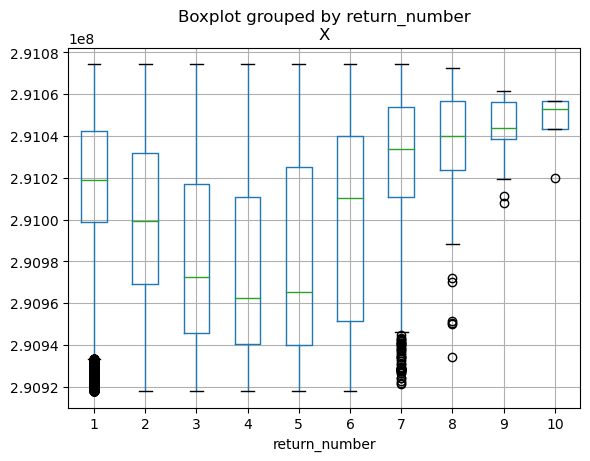

In [28]:
combined_df.boxplot(column='X', by='return_number')


<AxesSubplot: title={'center': 'X'}, xlabel='classification'>

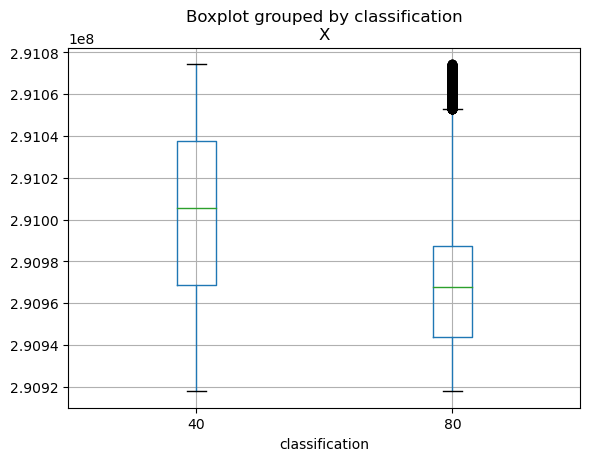

In [29]:
combined_df.boxplot(column='X', by='classification')


[15067 13901 14135 13464 13993 14249 14800 14391 14061 14605 17628 19303
 19139 18244 17690 18342 19160 20658 19635 19001 18490 18078 17697 17305
 17211 16890 15520 14780 14072 13616]
[290917.873      290923.09196667 290928.31093333 290933.5299
 290938.74886667 290943.96783333 290949.1868     290954.40576667
 290959.62473333 290964.8437     290970.06266667 290975.28163333
 290980.5006     290985.71956667 290990.93853333 290996.1575
 291001.37646667 291006.59543333 291011.8144     291017.03336667
 291022.25233333 291027.4713     291032.69026667 291037.90923333
 291043.1282     291048.34716667 291053.56613333 291058.7851
 291064.00406667 291069.22303333 291074.442     ]


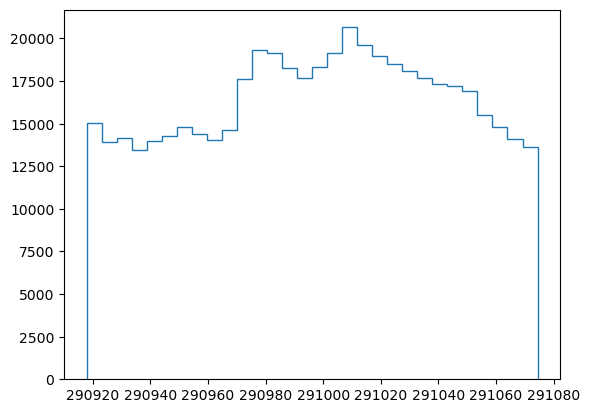

In [30]:
counts, bins = np.histogram(combined_df.x,bins=30)
print(counts)
print(bins)
plt.stairs(counts, bins)

Y stats

<AxesSubplot: title={'center': 'Y'}, xlabel='classification'>

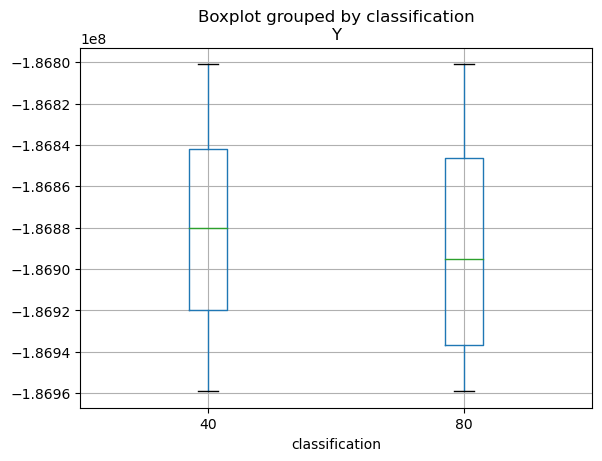

In [31]:
combined_df.boxplot(column='Y', by='classification')


[52489 52339 52097 52307 51554 49432 48426 48307 47772 48864 48869 48581
 48305 48473 48026 49007 49103 49741 50531 51436 50002 50491 50899 51169
 49148 46836 45649 45165 45120 45541]
[-1.86959113e+08 -1.86953840e+08 -1.86948567e+08 -1.86943294e+08
 -1.86938021e+08 -1.86932748e+08 -1.86927475e+08 -1.86922202e+08
 -1.86916928e+08 -1.86911655e+08 -1.86906382e+08 -1.86901109e+08
 -1.86895836e+08 -1.86890563e+08 -1.86885290e+08 -1.86880017e+08
 -1.86874744e+08 -1.86869471e+08 -1.86864198e+08 -1.86858925e+08
 -1.86853652e+08 -1.86848379e+08 -1.86843106e+08 -1.86837832e+08
 -1.86832559e+08 -1.86827286e+08 -1.86822013e+08 -1.86816740e+08
 -1.86811467e+08 -1.86806194e+08 -1.86800921e+08]


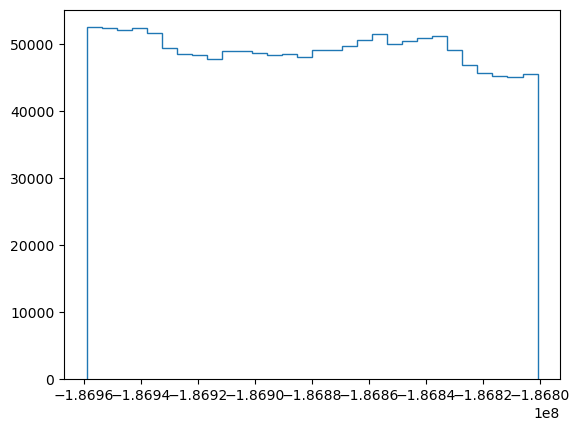

In [213]:
counts, bins = np.histogram(combined_df.Y,bins=30)
print(counts)
print(bins)
plt.stairs(counts, bins)

In [214]:
combined_df.Z.max(),combined_df.Z.min(),combined_df.Z.max()-combined_df.Z.min()

(115792, -37933, 153725)

[     1      0   1389   6210  17698 247943 409279 793123      0      0
      0      0      0      1      0      1      0      0      0      1
      9      5      4      3      3      3      2      0      0      4]
[-37933.         -32808.83333333 -27684.66666667 -22560.5
 -17436.33333333 -12312.16666667  -7188.          -2063.83333333
   3060.33333333   8184.5         13308.66666667  18432.83333333
  23557.          28681.16666667  33805.33333333  38929.5
  44053.66666667  49177.83333333  54302.          59426.16666667
  64550.33333333  69674.5         74798.66666667  79922.83333333
  85047.          90171.16666667  95295.33333333 100419.5
 105543.66666667 110667.83333333 115792.        ]


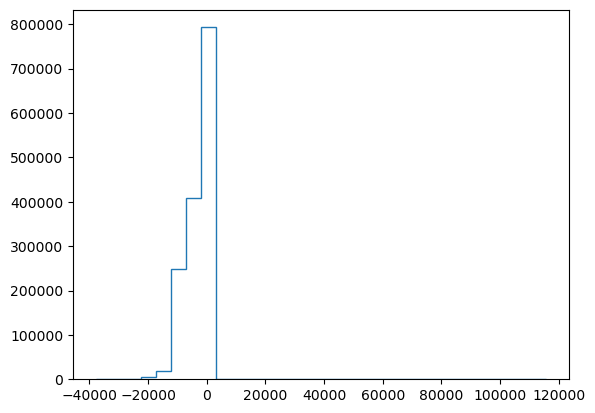

In [215]:
counts, bins = np.histogram(combined_df.Z,bins=30)
print(counts)
print(bins)
plt.stairs(counts, bins)

As we can see the precence of outliers exist.

## Outlier detection

In [216]:
print(combined_df.Z.skew())


-0.8521625999962137


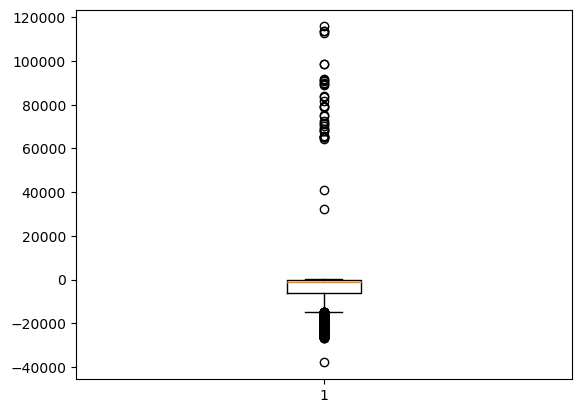

In [217]:
plt.boxplot(combined_df["Z"])
plt.show()

<AxesSubplot: title={'center': 'Z'}, xlabel='classification'>

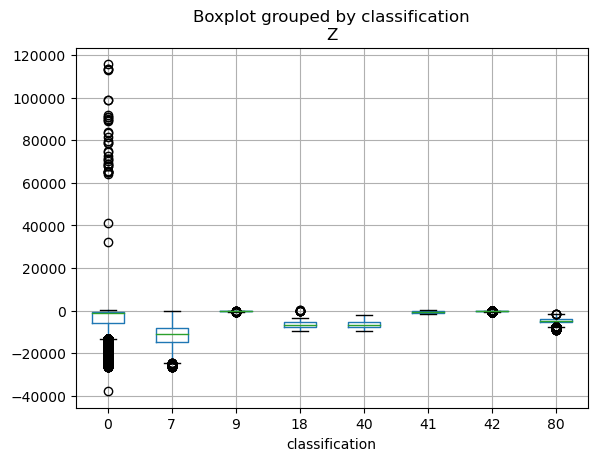

In [218]:
combined_df.boxplot(column='Z', by='classification')


Capping techniques with interquartile ranges.

In [219]:
print(combined_df.Z.min())

print("InterQuartile R1: ",combined_df.Z.quantile(0.10))
print("InterQuartile R2: ",combined_df.Z.quantile(0.90))

print(combined_df.Z.max())

-37933
InterQuartile R1:  -8076.0
InterQuartile R2:  -274.0
115792


In [227]:
combined_df

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
17,290981863,-186802952,-543,290981.863,4813197.048,-0.543,40234,0,1,2,0,0,0,0,0,1,1,-1557,2610,135243.804600
18,290981898,-186803276,-1803,290981.898,4813196.724,-1.803,13772,0,2,2,0,0,0,0,0,1,1,-1557,2610,135243.804600
51,290976250,-186806358,-579,290976.250,4813193.642,-0.579,40878,0,1,2,0,0,0,0,0,1,1,-1481,2610,135243.875758
52,290976273,-186806680,-1841,290976.273,4813193.320,-1.841,13665,0,2,2,0,0,0,0,0,1,1,-1481,2610,135243.875758
145,290993629,-186816313,-1785,290993.629,4813183.687,-1.785,12912,0,2,2,0,0,0,0,0,1,1,-1949,2610,135243.960714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475630,291019886,-186958735,-5806,291019.886,4813041.265,-5.806,4457,80,5,6,0,0,0,0,0,0,4,2643,2812,135839.330419
1475638,291024783,-186958751,-5775,291024.783,4813041.249,-5.775,743,80,4,5,0,0,0,0,0,0,4,2556,2812,135839.330521
1475645,291028322,-186958909,-5577,291028.322,4813041.091,-5.577,1920,80,3,4,0,0,0,0,0,0,4,2492,2812,135839.330593
1475648,291029709,-186958932,-5777,291029.709,4813041.068,-5.777,8561,80,3,4,0,0,0,0,0,0,4,2466,2812,135839.330622


In [240]:
combined_df_denoised=combined_df[(combined_df["Z"] > combined_df.Z.quantile(0.10)) & (combined_df["Z"] < combined_df.Z.quantile(0.90))]

combined_df_denoised

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
17,290981863,-186802952,-543,290981.863,4813197.048,-0.543,40234,0,1,2,0,0,0,0,0,1,1,-1557,2610,135243.804600
18,290981898,-186803276,-1803,290981.898,4813196.724,-1.803,13772,0,2,2,0,0,0,0,0,1,1,-1557,2610,135243.804600
51,290976250,-186806358,-579,290976.250,4813193.642,-0.579,40878,0,1,2,0,0,0,0,0,1,1,-1481,2610,135243.875758
52,290976273,-186806680,-1841,290976.273,4813193.320,-1.841,13665,0,2,2,0,0,0,0,0,1,1,-1481,2610,135243.875758
145,290993629,-186816313,-1785,290993.629,4813183.687,-1.785,12912,0,2,2,0,0,0,0,0,1,1,-1949,2610,135243.960714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475630,291019886,-186958735,-5806,291019.886,4813041.265,-5.806,4457,80,5,6,0,0,0,0,0,0,4,2643,2812,135839.330419
1475638,291024783,-186958751,-5775,291024.783,4813041.249,-5.775,743,80,4,5,0,0,0,0,0,0,4,2556,2812,135839.330521
1475645,291028322,-186958909,-5577,291028.322,4813041.091,-5.577,1920,80,3,4,0,0,0,0,0,0,4,2492,2812,135839.330593
1475648,291029709,-186958932,-5777,291029.709,4813041.068,-5.777,8561,80,3,4,0,0,0,0,0,0,4,2466,2812,135839.330622


<AxesSubplot: title={'center': 'Z'}, xlabel='classification'>

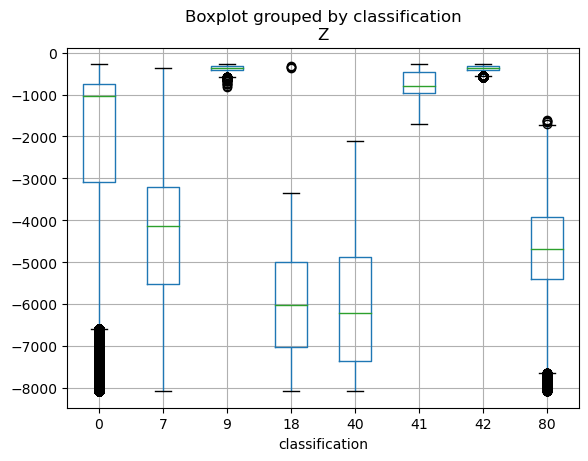

In [241]:
combined_df_denoised.boxplot(column='Z', by='classification')


In [242]:

print(combined_df_denoised.Z.skew())

-0.5324181517023181


In [261]:
combined_df_denoised[["X","Y","Z","classification"]]

,X,Y,Z,classification
17,290981863,-186802952,-543,0
18,290981898,-186803276,-1803,0
51,290976250,-186806358,-579,0
52,290976273,-186806680,-1841,0
145,290993629,-186816313,-1785,0
...,...,...,...,...
1475630,291019886,-186958735,-5806,80
1475638,291024783,-186958751,-5775,80
1475645,291028322,-186958909,-5577,80
1475648,291029709,-186958932,-5777,80


In [300]:
combined_df_denoised_0=combined_df_denoised[combined_df_denoised.classification == 0]
combined_df_denoised_42=combined_df_denoised[combined_df_denoised.classification == 42]
combined_df_denoised_80=combined_df_denoised[combined_df_denoised.classification == 80]

combined_df_denoised_42_80=combined_df_denoised[(combined_df_denoised.classification == 80) | (combined_df_denoised.classification == 42)]

combined_df_denoised_0_filtered=combined_df_denoised_0[combined_df_denoised_0.Z < -6000]
#combined_df_denoised_42_80

In [291]:
print(combined_df_denoised_42_80.Z.max())
print(combined_df_denoised_42_80.Z.min())

-275
-8075


In [297]:
print(combined_df_denoised_42_80[combined_df_denoised_42_80["classification"] == 42].Z.max())
print(combined_df_denoised_42_80[combined_df_denoised_42_80["classification"] == 42].Z.min())

-275
-587


In [298]:
print(combined_df_denoised_42_80[combined_df_denoised_42_80["classification"] == 80].Z.max())
print(combined_df_denoised_42_80[combined_df_denoised_42_80["classification"] == 80].Z.min())

-1596
-8075


<AxesSubplot: title={'center': 'Z'}, xlabel='classification'>

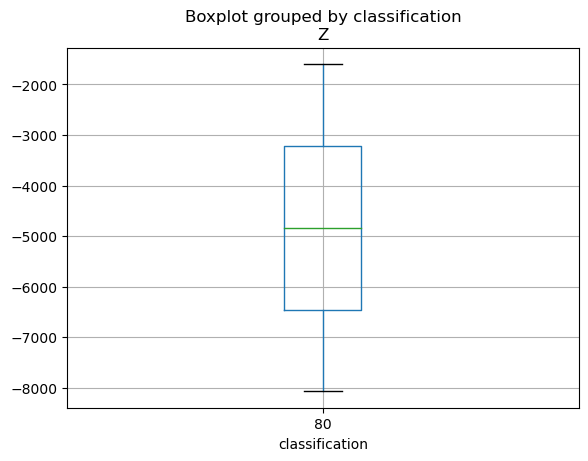

<AxesSubplot: title={'center': 'Z'}, xlabel='classification'>

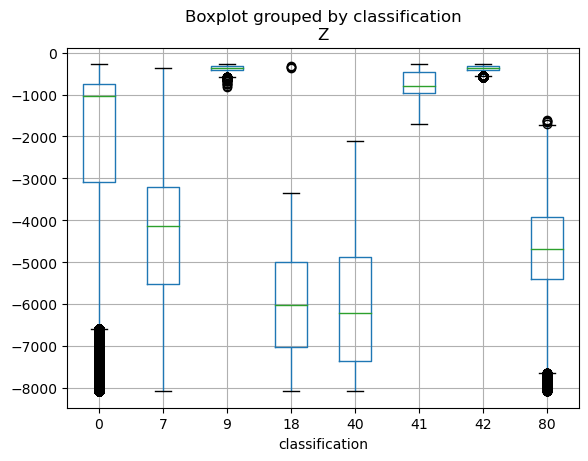

In [332]:
#combined_df_denoised_range = combined_df_denoised[ (combined_df_denoised["Z"] == combined_df_denoised["Z"].max()   ) | (combined_df_denoised["Z"] < -7000) ]

combined_df_denoised_80_range = combined_df_denoised_80[(combined_df_denoised_80["Z"] < -1596) & (combined_df_denoised_80["Z"] > -2000)]

#combined_df_denoised_80.boxplot(column='Z', by='classification')

combined_df_denoised.boxplot(column='Z', by='classification')


In [331]:
visualize_las(np.array(combined_df_denoised_80_range[["X","Y","Z"]]))

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
did not enter df


# Full Point cloud intensity distribution

In [32]:
counts, bins = np.histogram(combined_df.intensity,bins=30)

In [33]:
counts

array([10945, 24919, 34356, 43855, 43722, 37955, 32381, 28996, 27387,
       26734, 27051, 28059, 28486, 26682, 23514, 19690, 13973,  8220,
        4252,  1936,   965,   469,   256,   140,    84,    51,    23,
          18,     4,     2])

In [34]:
bins

array([  351. ,  1749.2,  3147.4,  4545.6,  5943.8,  7342. ,  8740.2,
       10138.4, 11536.6, 12934.8, 14333. , 15731.2, 17129.4, 18527.6,
       19925.8, 21324. , 22722.2, 24120.4, 25518.6, 26916.8, 28315. ,
       29713.2, 31111.4, 32509.6, 33907.8, 35306. , 36704.2, 38102.4,
       39500.6, 40898.8, 42297. ])

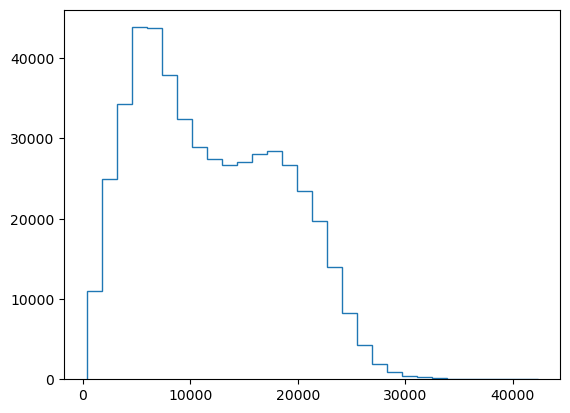

In [35]:
plt.stairs(counts, bins)

(array([1.69398e+05, 1.46740e+05, 1.36148e+05, 9.75020e+04, 6.66940e+04,
        5.07550e+04, 4.48910e+04, 4.27940e+04, 4.18490e+04, 4.16620e+04,
        4.20180e+04, 3.92300e+04, 3.41450e+04, 2.80860e+04, 1.95640e+04,
        1.18840e+04, 7.44000e+03, 5.39600e+03, 4.12600e+03, 3.47400e+03,
        2.88000e+03, 2.45000e+03, 1.98200e+03, 1.70400e+03, 1.36800e+03,
        1.13900e+03, 9.34000e+02, 7.97000e+02, 5.99000e+02, 5.09000e+02,
        4.07000e+02, 3.60000e+02, 2.62000e+02, 1.76000e+02, 1.32000e+02,
        1.09000e+02, 5.70000e+01, 3.10000e+01, 2.30000e+01, 4.25964e+05]),
 array([  313.   ,  1943.425,  3573.85 ,  5204.275,  6834.7  ,  8465.125,
        10095.55 , 11725.975, 13356.4  , 14986.825, 16617.25 , 18247.675,
        19878.1  , 21508.525, 23138.95 , 24769.375, 26399.8  , 28030.225,
        29660.65 , 31291.075, 32921.5  , 34551.925, 36182.35 , 37812.775,
        39443.2  , 41073.625, 42704.05 , 44334.475, 45964.9  , 47595.325,
        49225.75 , 50856.175, 52486.6  , 541

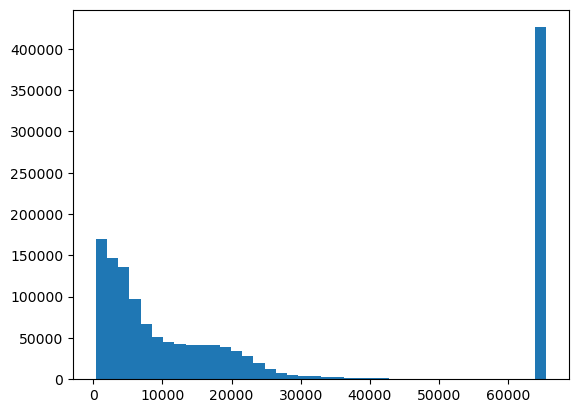

In [72]:
plt.hist(combined_df.intensity,bins=40)

In [36]:
np.unique((list(combined_df[combined_df["intensity"] > 50000]["classification"])),return_counts=True)

(array([], dtype=float64), array([], dtype=int64))

Derived water surface

In [37]:
combined_df[combined_df["classification"] == 42]

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <BarContainer object of 40 artists>)

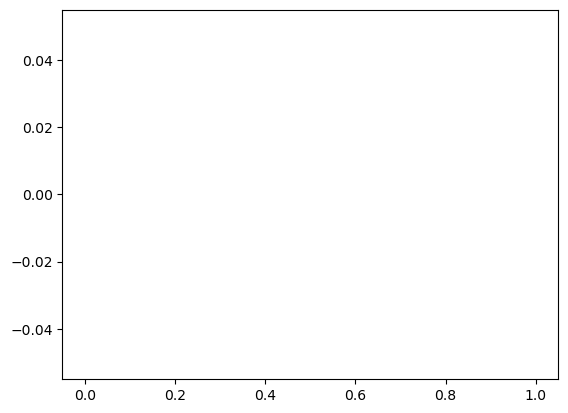

In [38]:
plt.hist(combined_df[combined_df["classification"] == 42].intensity,bins=40)

In [79]:
combined_df[combined_df["classification"] == 42].Z.mean()

-334.52217255336535

In [80]:
combined_df.Z.max()

115792

In [81]:
combined_df.Z.min()

-37933

Bathymetry vegetation

In [41]:
#bathy_veg_unscaled
bathy_veg.shape

(57401, 20)

In [42]:
bathy_veg

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
2601,290992999,-186802064,-5923,290992.999,4813197.936,-5.923,16914,80,1,6,0,0,0,0,0,1,2,-1760,2610,135243.746899
2607,290991766,-186801812,-5849,290991.766,4813198.188,-5.849,22487,80,2,3,0,0,0,0,0,1,2,-1732,2610,135243.746928
2629,290996698,-186803948,-6024,290996.698,4813196.052,-6.024,22124,80,1,2,0,0,0,0,0,1,2,-1856,2610,135243.765407
2649,290989339,-186802534,-5822,290989.339,4813197.466,-5.822,15202,80,2,5,0,0,0,0,0,1,2,-1691,2610,135243.765580
2739,290997434,-186806481,-6080,290997.434,4813193.519,-6.080,23758,80,1,3,0,0,0,0,0,1,2,-1899,2610,135243.802579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475630,291019886,-186958735,-5806,291019.886,4813041.265,-5.806,4457,80,5,6,0,0,0,0,0,0,4,2643,2812,135839.330419
1475638,291024783,-186958751,-5775,291024.783,4813041.249,-5.775,743,80,4,5,0,0,0,0,0,0,4,2556,2812,135839.330521
1475645,291028322,-186958909,-5577,291028.322,4813041.091,-5.577,1920,80,3,4,0,0,0,0,0,0,4,2492,2812,135839.330593
1475648,291029709,-186958932,-5777,291029.709,4813041.068,-5.777,8561,80,3,4,0,0,0,0,0,0,4,2466,2812,135839.330622


In [44]:
bathy_veg.describe()

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
count,5.740100e+04,5.740100e+04,57401.000000,57401.000000,5.740100e+04,57401.000000,57401.000000,57401.0,57401.000000,57401.000000,57401.0,57401.0,57401.0,57401.0,57401.0,57401.000000,57401.000000,57401.000000,57401.000000,57401.000000
mean,2.909687e+08,-1.868902e+08,-4732.984878,290968.736343,4.813110e+06,-4.732985,6913.689971,80.0,2.370046,3.447605,0.0,0.0,0.0,0.0,0.0,0.467326,3.358530,-1123.354611,2684.326963,135516.417412
std,3.136763e+04,4.915423e+04,1129.743955,31.367627,4.915423e+01,1.129744,5161.345287,0.0,1.007557,1.158552,0.0,0.0,0.0,0.0,0.0,0.498936,0.933554,1764.047118,65.259249,217.616654
min,2.909179e+08,-1.869591e+08,-9021.000000,290917.905000,4.813041e+06,-9.021000,351.000000,80.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,-3589.000000,2610.000000,135243.698930
25%,2.909439e+08,-1.869367e+08,-5432.000000,290943.873000,4.813063e+06,-5.432000,3007.000000,80.0,2.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.000000,-2247.000000,2610.000000,135246.998727
50%,2.909676e+08,-1.868951e+08,-4703.000000,290967.638000,4.813105e+06,-4.703000,5688.000000,80.0,2.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.000000,4.000000,-1559.000000,2711.000000,135642.612572
75%,2.909875e+08,-1.868465e+08,-3932.000000,290987.477000,4.813153e+06,-3.932000,9381.000000,80.0,3.000000,4.000000,0.0,0.0,0.0,0.0,0.0,1.000000,4.000000,-676.000000,2711.000000,135645.869099
max,2.910744e+08,-1.868010e+08,-1596.000000,291074.353000,4.813199e+06,-1.596000,42297.000000,80.0,9.000000,11.000000,0.0,0.0,0.0,0.0,0.0,1.000000,4.000000,3639.000000,2812.000000,135839.330637


Bathymetry intensity distribution

(array([4.266e+03, 6.703e+03, 6.264e+03, 5.657e+03, 5.373e+03, 4.836e+03,
        4.343e+03, 3.635e+03, 3.086e+03, 2.434e+03, 2.133e+03, 1.638e+03,
        1.373e+03, 1.126e+03, 8.690e+02, 7.310e+02, 6.070e+02, 4.680e+02,
        3.980e+02, 3.380e+02, 2.700e+02, 2.190e+02, 1.600e+02, 1.190e+02,
        9.300e+01, 5.900e+01, 5.300e+01, 4.000e+01, 2.400e+01, 2.500e+01,
        1.600e+01, 1.500e+01, 6.000e+00, 9.000e+00, 1.000e+00, 5.000e+00,
        5.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([  351.  ,  1399.65,  2448.3 ,  3496.95,  4545.6 ,  5594.25,
         6642.9 ,  7691.55,  8740.2 ,  9788.85, 10837.5 , 11886.15,
        12934.8 , 13983.45, 15032.1 , 16080.75, 17129.4 , 18178.05,
        19226.7 , 20275.35, 21324.  , 22372.65, 23421.3 , 24469.95,
        25518.6 , 26567.25, 27615.9 , 28664.55, 29713.2 , 30761.85,
        31810.5 , 32859.15, 33907.8 , 34956.45, 36005.1 , 37053.75,
        38102.4 , 39151.05, 40199.7 , 41248.35, 42297.  ]),
 <BarContainer object of 40 artist

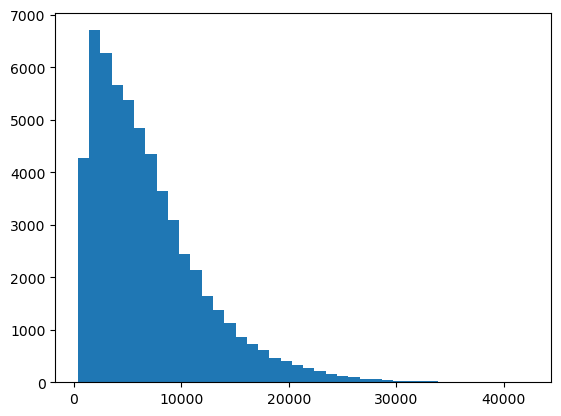

In [64]:
plt.hist(bathy_veg.intensity,bins=40)

In [20]:
bathy_veg.X.max(),bathy_veg.X.min(),g.X.mbathy_veg.X.max()-bathy_vein()

(291074353, 290917905, 156448)

In [21]:
bathy_veg.Y.max(),bathy_veg.Y.min(),bathy_veg.Y.max()-bathy_veg.Y.min()

(-186800961, -186959090, 158129)

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [10]:
from sklearn.preprocessing import StandardScaler

combined_df_XYZ = combined_df[["X","Y","Z"]]
scaler = StandardScaler()
scaler.fit(combined_df_XYZ)
combined_df_XYZ_scaled = scaler.transform(combined_df_XYZ)

scaler = StandardScaler()
scaler.fit(combined_df)
combined_df_scaled = scaler.transform(combined_df)
scaled_features_df = pd.DataFrame(combined_df_scaled, index=combined_df.index, columns=combined_df.columns)
#scaled_features_df

visualize_las(classified_points=combined_df_XYZ_scaled,df=scaled_features_df[["X","Y","Z"]])

entered df
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [11]:
from sklearn.preprocessing import StandardScaler

bathy_veg_df_XYZ = bathy_veg[["X","Y","Z"]]
scaler = StandardScaler()
scaler.fit(bathy_veg_df_XYZ)
bathy_veg_pd_XYZ_scaled = scaler.transform(bathy_veg_df_XYZ)

scaler = StandardScaler()
scaler.fit(bathy_veg)
bathy_veg_scaled = scaler.transform(bathy_veg)
bathy_veg_scaled_df = pd.DataFrame(bathy_veg_scaled, index=bathy_veg.index, columns=bathy_veg.columns)
#scaled_features_df

visualize_las(classified_points=bathy_veg_pd_XYZ_scaled,df=bathy_veg_scaled_df[["X","Y","Z"]])

entered df
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [13]:
#derived_water_surface
from sklearn.preprocessing import StandardScaler
derived_water_surface_pd_XYZ = derived_water_surface[["X","Y","Z"]]
scaler = StandardScaler()
scaler.fit(derived_water_surface_pd_XYZ)
derived_water_surface_XYZ_scaled = scaler.transform(derived_water_surface_pd_XYZ)

scaler = StandardScaler()
scaler.fit(derived_water_surface)
derived_water_surface_scaled = scaler.transform(derived_water_surface)
derived_water_surface_scaled_df = pd.DataFrame(derived_water_surface_scaled, index=derived_water_surface.index, columns=derived_water_surface.columns)


visualize_las(classified_points=derived_water_surface_XYZ_scaled,df=derived_water_surface_scaled_df[["X","Y","Z"]])


 

entered df
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [322]:
from sklearn.preprocessing import MinMaxScaler
combined_df_XYZ = combined_df[["X","Y","Z"]]
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(combined_df_XYZ)
combined_df_XYZ_scaled = scaler.transform(combined_df_XYZ)

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(combined_df)
combined_df_scaled = scaler.transform(combined_df)
scaled_features_df = pd.DataFrame(combined_df_scaled, index=combined_df.index, columns=combined_df.columns)
#scaled_features_df

visualize_las(classified_points=combined_df_XYZ_scaled,df=scaled_features_df[["X","Y","Z"]])

entered df


In [325]:
from sklearn.preprocessing import MinMaxScaler

bathy_veg_df_XYZ = bathy_veg[["X","Y","Z"]]
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(bathy_veg_df_XYZ)
bathy_veg_pd_XYZ_scaled = scaler.transform(bathy_veg_df_XYZ)

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(bathy_veg)
bathy_veg_scaled = scaler.transform(bathy_veg)
bathy_veg_scaled_df = pd.DataFrame(bathy_veg_scaled, index=bathy_veg.index, columns=bathy_veg.columns)
#scaled_features_df

visualize_las(classified_points=bathy_veg_pd_XYZ_scaled,df=bathy_veg_scaled_df[["X","Y","Z"]])

entered df


In [14]:
#derived_water_surface
from sklearn.preprocessing import MinMaxScaler
derived_water_surface_pd_XYZ = derived_water_surface[["X","Y","Z"]]
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(derived_water_surface_pd_XYZ)
derived_water_surface_XYZ_scaled = scaler.transform(derived_water_surface_pd_XYZ)

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(derived_water_surface)
derived_water_surface_scaled = scaler.transform(derived_water_surface)
derived_water_surface_scaled_df = pd.DataFrame(derived_water_surface_scaled, index=derived_water_surface.index, columns=derived_water_surface.columns)


visualize_las(classified_points=derived_water_surface_XYZ_scaled,df=derived_water_surface_scaled_df[["X","Y","Z"]])


 

entered df
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [330]:
derived_water_surface

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
2583,290998856,-186802008,-284,290998.856,4813197.992,-0.284,65530,42,0,2,0,0,0,0,0,1,2,-1897,2610,135243.746754
2586,290997639,-186801812,-280,290997.639,4813198.188,-0.280,65530,42,0,1,0,0,0,0,0,1,2,-1869,2610,135243.746783
2588,290996426,-186801609,-273,290996.426,4813198.391,-0.273,65530,42,0,5,0,0,0,0,0,1,2,-1842,2610,135243.746812
2594,290995196,-186801391,-257,290995.196,4813198.609,-0.257,65530,42,0,3,0,0,0,0,0,1,2,-1815,2610,135243.746841
2598,290993964,-186801165,-244,290993.964,4813198.835,-0.244,65530,42,0,1,0,0,0,0,0,1,2,-1787,2610,135243.746871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475458,291022825,-186959005,-251,291022.825,4813040.995,-0.251,65530,42,0,2,0,0,0,0,0,0,4,2610,2812,135839.302463
1475461,291024199,-186959004,-242,291024.199,4813040.996,-0.242,65530,42,0,3,0,0,0,0,0,0,4,2585,2812,135839.302492
1475465,291025607,-186959020,-226,291025.607,4813040.980,-0.226,65530,42,0,3,0,0,0,0,0,0,4,2560,2812,135839.302521
1475469,291027003,-186959050,-212,291027.003,4813040.950,-0.212,65530,42,0,2,0,0,0,0,0,0,4,2534,2812,135839.302550


In [15]:
from sklearn.decomposition import PCA

derived_water_surface_pd_XYZ = derived_water_surface[["X","Y","Z","intensity"]]

pca = PCA(n_components=3)
 
PC = pca.fit_transform(derived_water_surface_XYZ_scaled)

pca_cloud = pd.DataFrame(data = PC,
              columns = ['PC1', 'PC2','PC3'])
 
pca_cloud.head(6)

,PC1,PC2,PC3
0,-0.395324,0.291430,0.114549
1,-0.392279,0.297619,0.123059
2,-0.389515,0.303161,0.137240
3,-0.387453,0.306886,0.168453
4,-0.385197,0.311304,0.193998
5,-0.381936,0.318740,0.191147


In [329]:
pca_cloud

,PC1,PC2,PC3
0,-0.790647,0.582859,0.229098
1,-0.784559,0.595239,0.246118
2,-0.779029,0.606321,0.274480
3,-0.774905,0.613773,0.336907
4,-0.770393,0.622607,0.387995
...,...,...,...
425927,0.671340,-0.799616,0.255584
425928,0.660086,-0.817891,0.287568
425929,0.647700,-0.839687,0.345965
425930,0.635850,-0.860588,0.396811


In [16]:
visualize_las(np.array(pca_cloud),df=derived_water_surface[["X","Y","Z"]])

entered df
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [337]:
#derived_water_surface
from sklearn.preprocessing import MinMaxScaler
derived_water_surface_pd_XYZ = derived_water_surface[["X","Y","Z"]]
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(derived_water_surface_pd_XYZ)
derived_water_surface_XYZ_scaled = scaler.transform(derived_water_surface_pd_XYZ)

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(derived_water_surface)
derived_water_surface_scaled = scaler.transform(derived_water_surface)
derived_water_surface_scaled_df = pd.DataFrame(derived_water_surface_scaled, index=derived_water_surface.index, columns=derived_water_surface.columns)


visualize_las(classified_points=derived_water_surface_XYZ_scaled,df=derived_water_surface_scaled_df[["X","Y","Z"]])


 

entered df


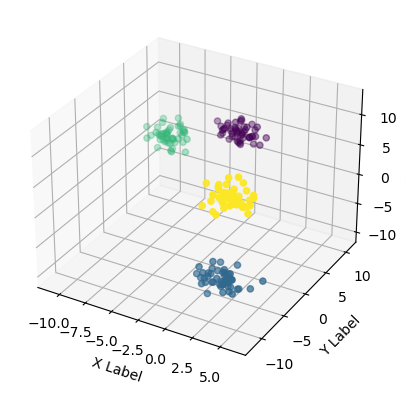

In [34]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate random 3-dimensional clusters
X, y  = make_blobs(n_samples=200,centers= 4,cluster_std=1,n_features=3,random_state=42)

# Plot the clusters in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [72]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(X)
o3d.io.write_point_cloud("./random_data.ply", pcd)


ply_point_cloud = o3d.data.PLYPointCloud()
pcd = o3d.io.read_point_cloud("random_data.ply")


True

In [5]:
import numpy as np
from sklearn.datasets import make_blobs
import open3d as o3d

# Generate random 3-dimensional clusters
X, labels  = make_blobs(n_samples=20000,centers= 2,cluster_std=2,n_features=3,random_state=42)

# Perform DBSCAN clustering on the data using Open3D
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(X)
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd.cluster_dbscan(eps=1, min_points=10, print_progress=True))

# Visualize the clusters using Open3D
colors = np.random.rand(np.max(labels) + 1, 3)
colors[0] = [0, 0, 0]  # set the color for unassigned points
pcd.colors = o3d.utility.Vector3dVector(colors[labels])
o3d.visualization.draw_geometries([pcd])

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2                       ] 2%
Precompute neighbors.[========================================] 100%
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [108]:
import numpy as np
from sklearn.datasets import make_blobs
import open3d as o3d

# Generate random 3-dimensional clusters
X, labels  = make_blobs(n_samples=2000,centers= 4,cluster_std=2,n_features=3,random_state=42)

# Perform DBSCAN clustering on the data using Open3D
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(X)
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd.cluster_dbscan(eps=1, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])



[Open3D DEBUG] Precompute neighbors.
Precompute neighbors.[========[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 6
point cloud has 6 clusters
Precompute neighbors.[========================================] 100%
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


Try this on lidar data

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
import open3d as o3d

# Generate random 3-dimensional clusters
#X, labels  = make_blobs(n_samples=2000,centers= 4,cluster_std=2,n_features=3,random_state=42)

# Perform DBSCAN clustering on the data using Open3D
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(classified_points_numpy_scaled_laspy)
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd.cluster_dbscan(eps=100, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])



: 

: 